
<h1><center><font size="10"'><strong>Exploratory Data Analysis for Tuberculosis</strong></font></center></h1>



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive



# Importing Packages

In [6]:
import pandas as pd
import numpy as np
import cv2
from skimage import io
from glob import glob
import os
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
from skimage.color import label2rgb
from pathlib import Path
import seaborn as sns
plt.style.use("seaborn")
import re

import warnings
warnings.simplefilter("ignore")

# Exploratory Data Analysis

## Distribution of Target Variable

In [3]:
# get count of non-TB images
count = 0
for (root, subFolders, files) in os.walk("/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Non-Tuberculosis/"):
   for filename in files:
      count+=1
   print(count)

0
0
3797
7597
7757
8409


In [4]:
# get count of TB images
count = 0
for (root, subFolders, files) in os.walk("/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/"):
   for filename in files:
      count+=1
   print(count)

0
200
991
1107
1779


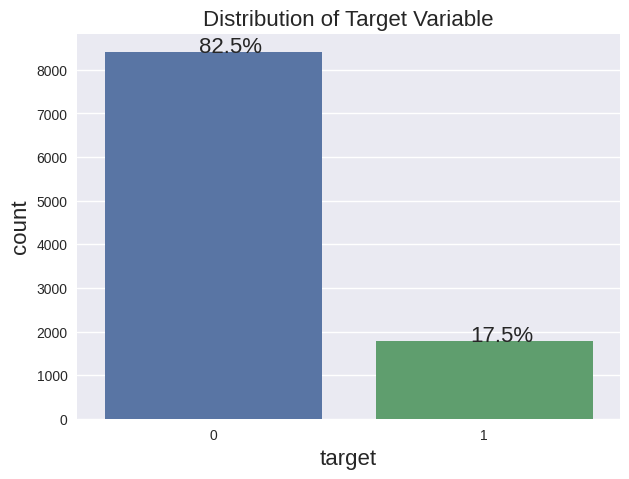

In [7]:
# create visualization to display distribution of target variable
path = Path("/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Non-Tuberculosis/")  # insert your path

files = []
for file in path.rglob('*.png'):  # loop recursively over all subdirectories
    files.append(file.name)

non_tb_df = pd.DataFrame(files, columns=['filename'])
non_tb_df['target'] = 0

path = Path("/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/")  # insert your path

files = []
for file in path.rglob('*.png'):  # loop recursively over all subdirectories
    files.append(file.name)

tb_df = pd.DataFrame(files, columns=['filename'])
tb_df['target'] = 1

target_df = pd.concat([tb_df, non_tb_df], axis=0)

# create visualization for target variable distribution
def barplot(df, xlabel, ylabel, title):
    plt.figure(figsize = (7,5))
    ax = sns.countplot(x = xlabel, data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    total = len(df.target)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 16)
    plt.show()

barplot(target_df, 'target', 'count', 'Distribution of Target Variable')


## Distributions of NIH dataset

In [8]:
# create dataframes from the clinical diagnosis files
df_list = []

for f in glob("/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Original Datasets/NIH Montgomery County CXR Set/ClinicalReadings/*.txt", recursive=True):
    data = pd.read_csv(f, sep=':', header=None)
    df_list.append(data)

diagnoses = [x.iloc[2, 0] for x in df_list]
ages = [int(x.iloc[1, 1][2:-1]) for x in df_list]
sex = [x.iloc[0, 1][1: -1] for x in df_list]

nih_mont_df = pd.DataFrame({"Age": ages, "Sex": sex, "Diagnosis": diagnoses,})
nih_mont_df['Source'] = 'Montgomery'

df_list = []

for f in glob("/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Original Datasets/NIH Shenzhen Hospital CXR Set/ClinicalReadings/*.txt", recursive=True):
    data = pd.read_csv(f, sep='\t', header=None)
    df_list.append(data)

diagnoses = [x.iloc[1, 0] for x in df_list]
sex_and_age = [x.iloc[0, 0] for x in df_list]
ages = [int(re.findall('\\d+', text)[0]) for text in sex_and_age]
sex = ['F' if re.search('f', text) else 'M' for text in sex_and_age]

nih_shen_df = pd.DataFrame({"Age": ages, "Sex": sex, "Diagnosis": diagnoses,})
nih_shen_df['Source'] = 'Shenzhen'

diagnosis_df = pd.concat([nih_mont_df, nih_shen_df], axis=0)

normal_df = diagnosis_df.loc[diagnosis_df.Diagnosis=='normal']
tb_df = diagnosis_df.loc[diagnosis_df.Diagnosis!='normal']


Text(0, 0.5, 'Count')

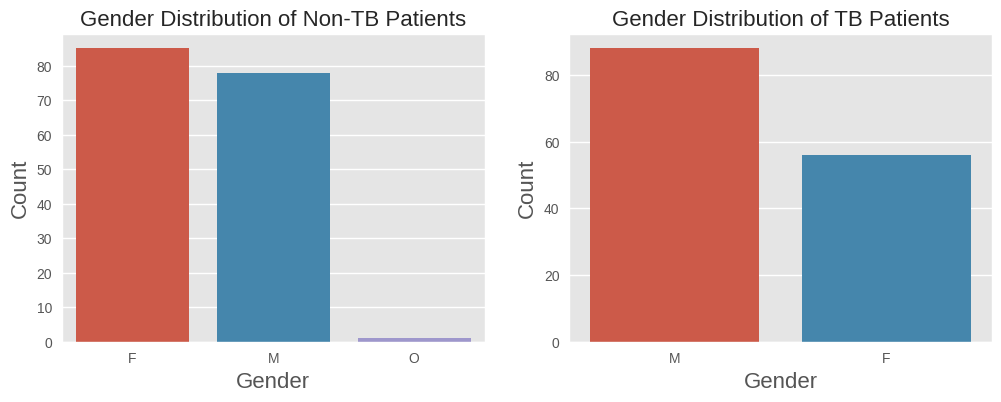

In [9]:
# display difference in gender distribution of TB vs. non-TB patients
plt.style.use('ggplot')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='Sex', data=normal_df, ax=ax1)
b = sns.countplot(x='Sex', data=tb_df, ax=ax2)
ax1.set_title("Gender Distribution of Non-TB Patients", fontsize=16)
ax2.set_title("Gender Distribution of TB Patients", fontsize=16)
ax1.set_xlabel('Gender', size=16)
ax1.set_ylabel('Count', size=16)
ax2.set_xlabel('Gender', size=16)
ax2.set_ylabel('Count', size=16)

Text(0, 0.5, 'Count')

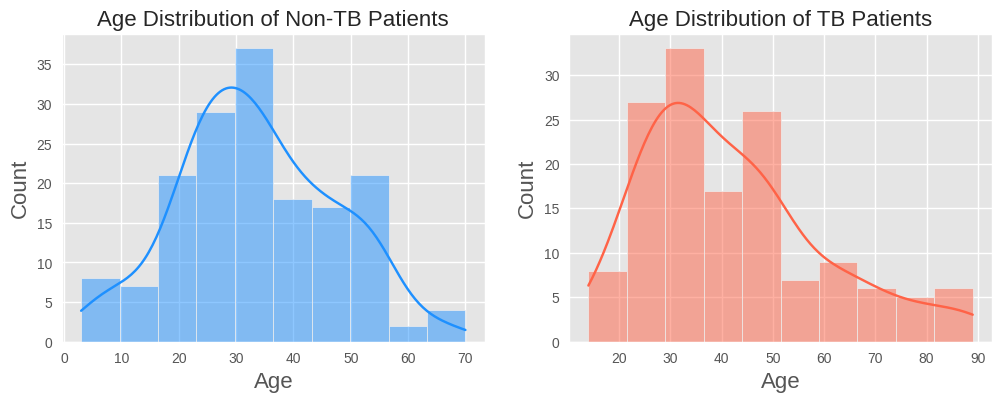

In [10]:
# create graphs to display distribution of age for non-TB vs. TB patients
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='Age', data=normal_df, kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='Age', data=tb_df, kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Non-TB Patients", fontsize=16)
ax2.set_title("Age Distribution of TB Patients", fontsize=16)
ax1.set_xlabel('Age', size=16)
ax1.set_ylabel('Count', size=16)
ax2.set_xlabel('Age', size=16)
ax2.set_ylabel('Count', size=16)

## Non-Tuberculosis Images

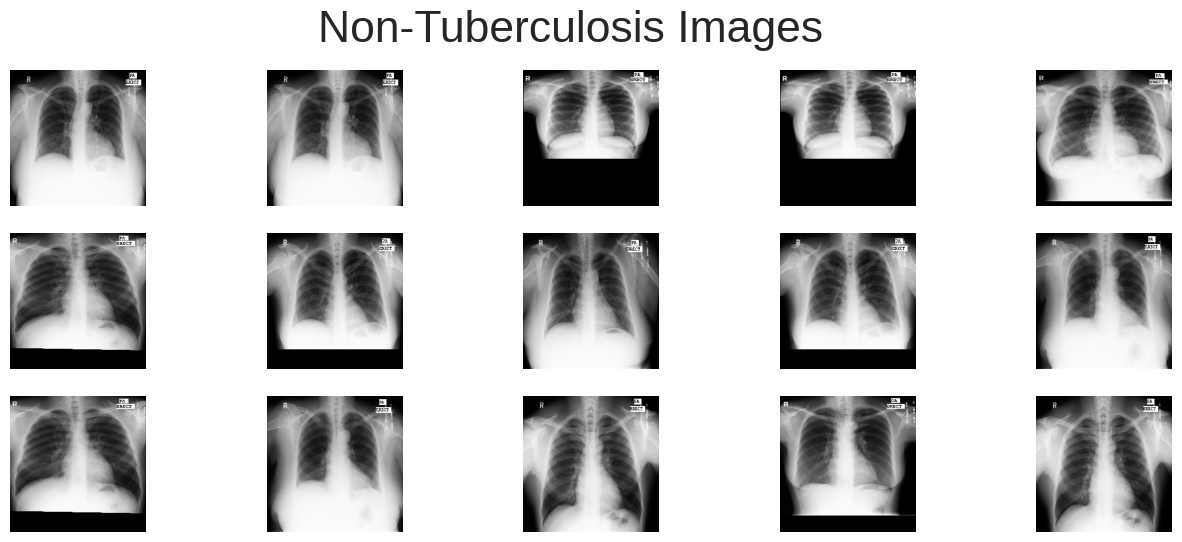

In [11]:
# display sample of non-TB images
plt.style.use('seaborn')
paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Non-Tuberculosis/NIH Montgomery/*.png')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 6))
plt.suptitle('Non-Tuberculosis Images', fontsize=32)
for i in range(0, 15):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image)
    axes[x, y].axis('off')

## Tuberculosis Images

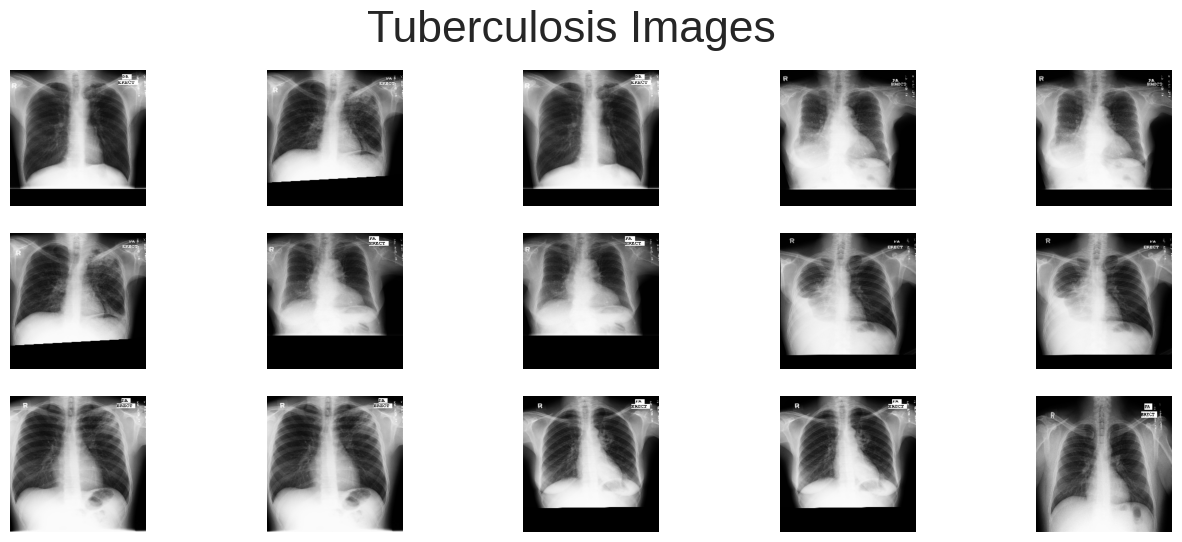

In [12]:
# display sample of TB images
plt.style.use('seaborn')
paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/NIH Montgomery/*.png')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 6))
plt.suptitle('Tuberculosis Images', fontsize=32)
for i in range(0, 15):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image)
    axes[x, y].axis('off')

## Augmentation Images

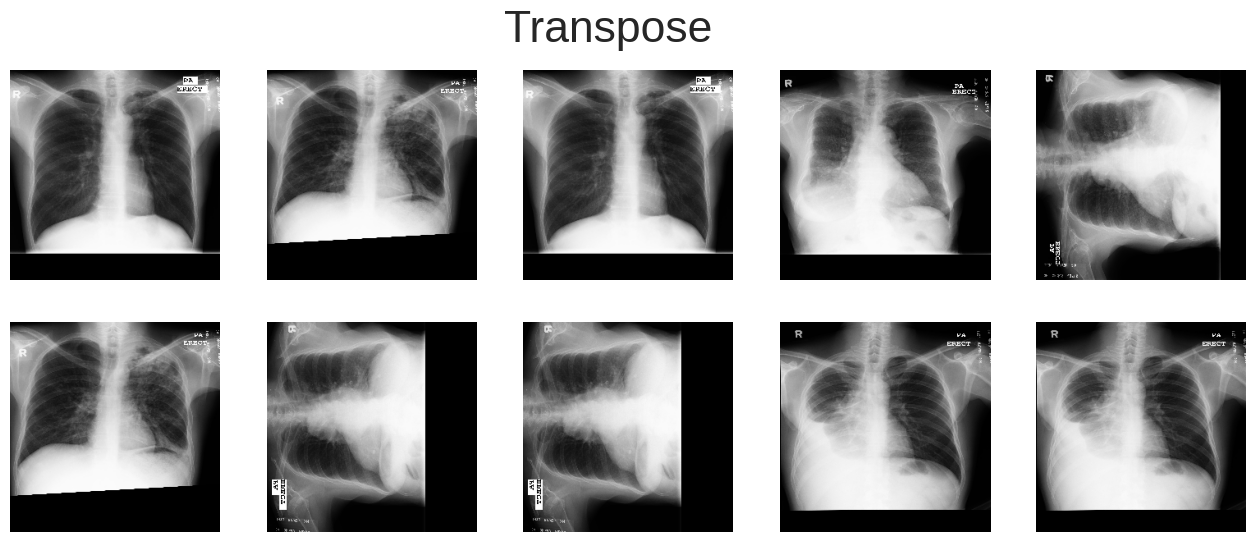

In [13]:
# display Transpose augmentations (rotates image)
transform = A.Compose([
    A.Transpose()
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/NIH Montgomery/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
plt.suptitle('Transpose', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    transformed = transform(image=image)
    aug_image = transformed['image']
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

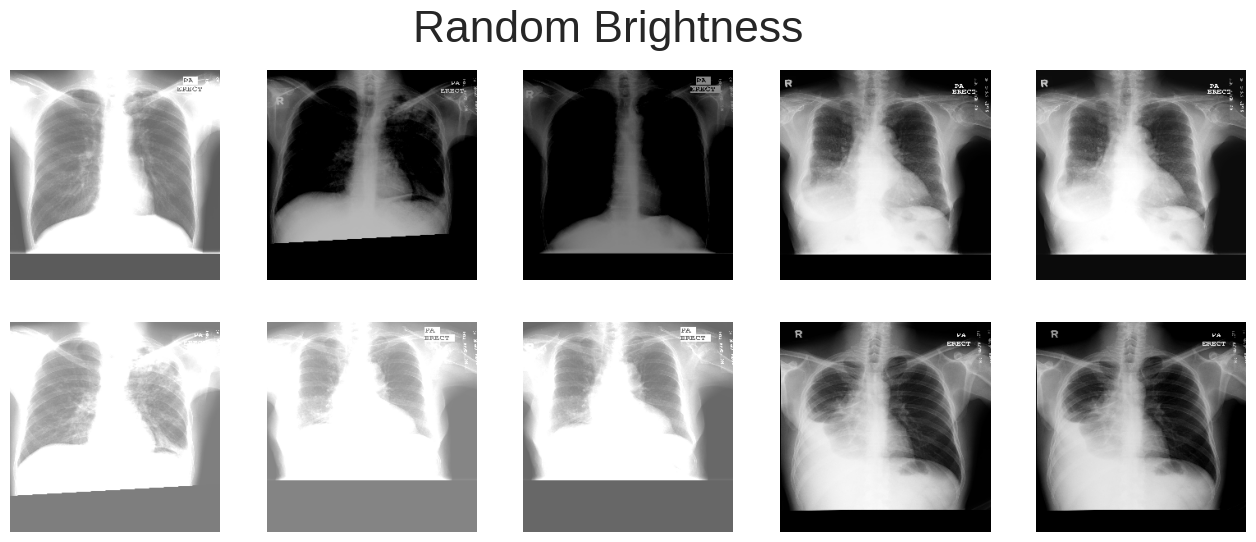

In [14]:
# display Random Brightness augmentations
transform = A.Compose([
    A.RandomBrightness(limit=0.6)
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/NIH Montgomery/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Random Brightness', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

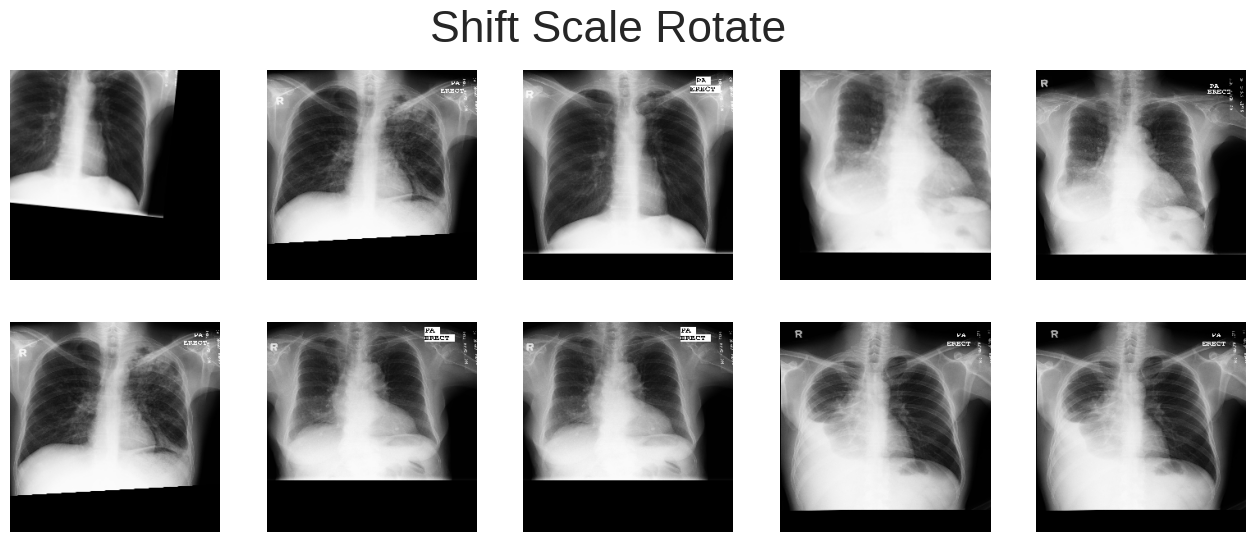

In [15]:
# display Shift Scale Rotate augmentations
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0)
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/NIH Montgomery/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Shift Scale Rotate', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

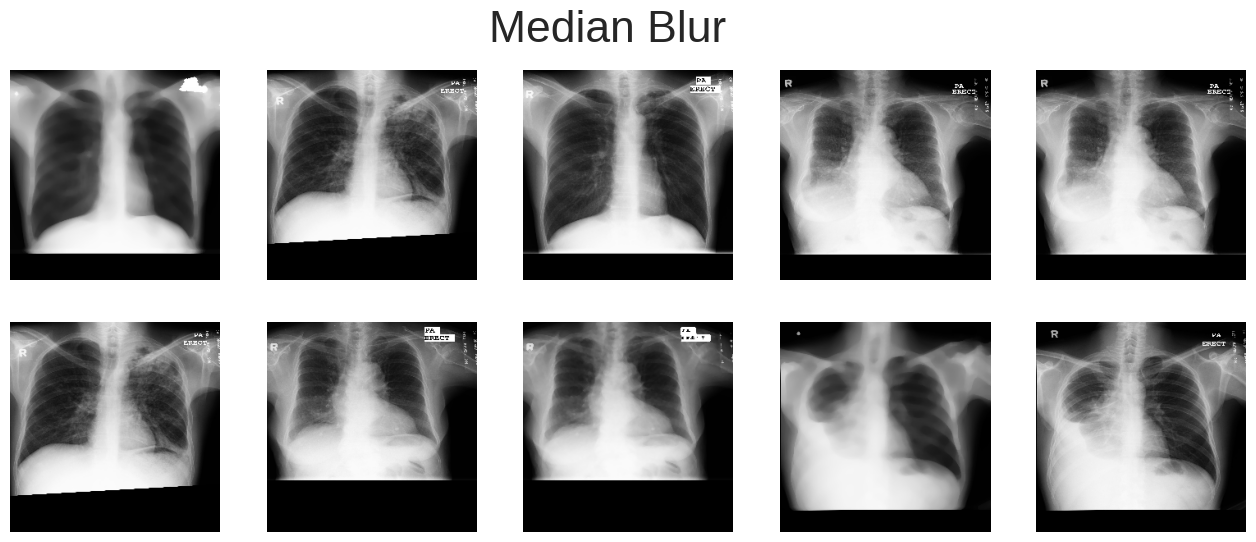

In [16]:
# display Median Blur augmentations
transform = A.Compose([
    A.MedianBlur(blur_limit=9)
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/NIH Montgomery/*.png')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Median Blur', fontsize=32)
for i in range(0, 10):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

## Augmentation Pipeline

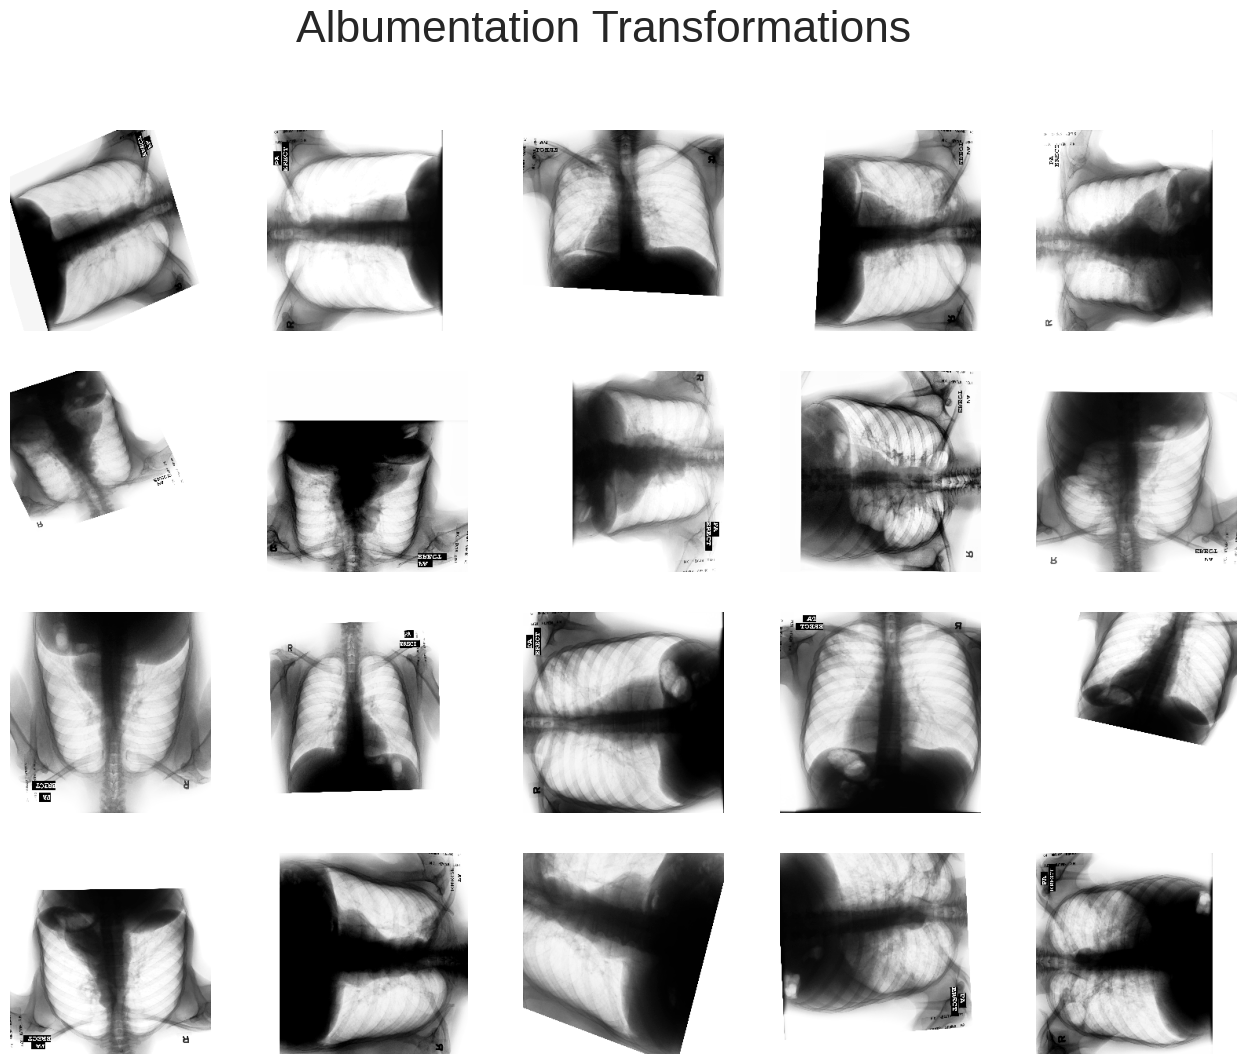

In [17]:
# defining augmentation pipeline
transform = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.3, p=0.5),
    A.RandomContrast(limit=0.3, p=0.5),
    # A.OneOf([
    #     A.MotionBlur(blur_limit=5),22
    #     A.MedianBlur(blur_limit=5),
    #     A.GaussianBlur(blur_limit=5),
    #     A.GaussNoise(var_limit=(5.0, 30.0)),
    # ], p=0.1),
    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.0),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.1),
    A.CLAHE(clip_limit=4.0, p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.4),
    A.Resize(256, 256),
    # A.Cutout(max_h_size=int(256 * 0.1), max_w_size=int(256 * 0.1), num_holes=1, p=0.2),
    # A.Normalize()
])

paths = glob('/gdrive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/Tuberculosis/NIH Montgomery/*.png')
path = sorted(paths)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16,12))
plt.suptitle('Albumentation Transformations', fontsize=32)
for i in range(0, 20):
    image = np.array(Image.open(path[i]))
    transformed = transform(image=image)
    aug_image = transformed['image']

    x = i // 5
    y = i % 5

    axes[x, y].imshow(aug_image)
    axes[x, y].axis('off')

